In [ ]:
#| hide
!pip install -Uqq nixtla
!pip install pandas_market_calendars

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Irregular and custom timestamps

When working with time series data, it is important to specify its frequency correctly, as this can significantly impact forecasting results. TimeGPT is designed to automatically infer the frequency of your timestamps. For commonly used frequencies, such as hourly, daily, or monthly, TimeGPT reliably infers the frequency automatically, so no additional input is required. 

However, for irregular frequencies, where observations are not recorded at consistent or regular intervals, such as the days the U.S. stock market is open, it is necessary to specify the frequency directly. 

TimeGPT requires that your data does not contain missing values, as this is not currently supported. In other words, the irregularity of the data should stem from the nature of the recorded phenomenon, not from missing observations. If your data contains missing values, please refer to our [tutorial on missing dates](https://docs.nixtla.io/docs/tutorials-missing_values).

In this tutorial, we will show you how to handle irregular and custom frequencies in TimeGPT.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/capabilities/forecast/11_irregular_timestamps')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/capabilities/forecast/11_irregular_timestamps.ipynb)

## 1. Import packages 

First, we import the required packages and initialize the Nixtla client. 

In [ ]:
import pandas as pd
import pandas_market_calendars as mcal
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Handling regular frequencies  

As discussed in the introduction, for time series data with regular frequencies, where observations are recorded at consistent intervals, TimeGPT can automatically infer the frequency of your timestamps if the input data is a **pandas DataFrame**. If you prefer not to rely on TimeGPT's automatic inference, you can set the `freq` parameter to a valid [pandas frequency string](https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases), such as `MS` for month-start frequency or `min` for minutely frequency.  

When working with **Polars DataFrames**, you must specify the frequency explicitly by using a valid [polars offset](https://docs.pola.rs/api/python/stable/reference/expressions/api/polars.Expr.dt.offset_by.html), such as `1d` for daily frequency or `1h` for hourly frequency. 

Below is an example of how to specify the frequency for a Polars DataFrame. 


In [ ]:
import polars as pl 

polars_df = pl.read_csv(
    'https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv',
    try_parse_dates=True,
)

polars_df 

fcst_df = nixtla_client.forecast(
    df=polars_df,
    h=12, 
    freq='1mo', 
    time_col='timestamp', 
    target_col='value'
)

fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


timestamp,TimeGPT
date,f64
1961-01-01,437.83792
1961-02-01,426.0627
1961-03-01,463.11655
1961-04-01,478.2445
1961-05-01,505.64648


## 3. Handling irregular frequencies

In this section, we will discuss cases where observations are not recorded at consistent intervals.

### 3.1 Load data 

We will use the daily stock prices of Palantir Technologies (PLTR) from 2020 to 2023. The dataset includes data up to 2023-09-22, but for this tutorial, we will exclude any data before 2023-08-28. This allows us to show how a custom frequency can handle days when the stock market is closed, such as Labor Day in the U.S. 

In [ ]:
pltr_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/openbb/pltr.csv', parse_dates=['date'])
pltr_df = pltr_df.query('date < "2023-08-28"')
pltr_df.head()

,date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2020-09-30,10.00,11.41,9.11,9.50,9.50,338584400,0.0,0.0
1,2020-10-01,9.69,10.10,9.23,9.46,9.46,124297600,0.0,0.0
2,2020-10-02,9.06,9.28,8.94,9.20,9.20,55018300,0.0,0.0
3,2020-10-05,9.43,9.49,8.92,9.03,9.03,36316900,0.0,0.0
4,2020-10-06,9.04,10.18,8.90,9.90,9.90,90864000,0.0,0.0


We will forecast the close price, so we will exclude the other columns from the dataset.

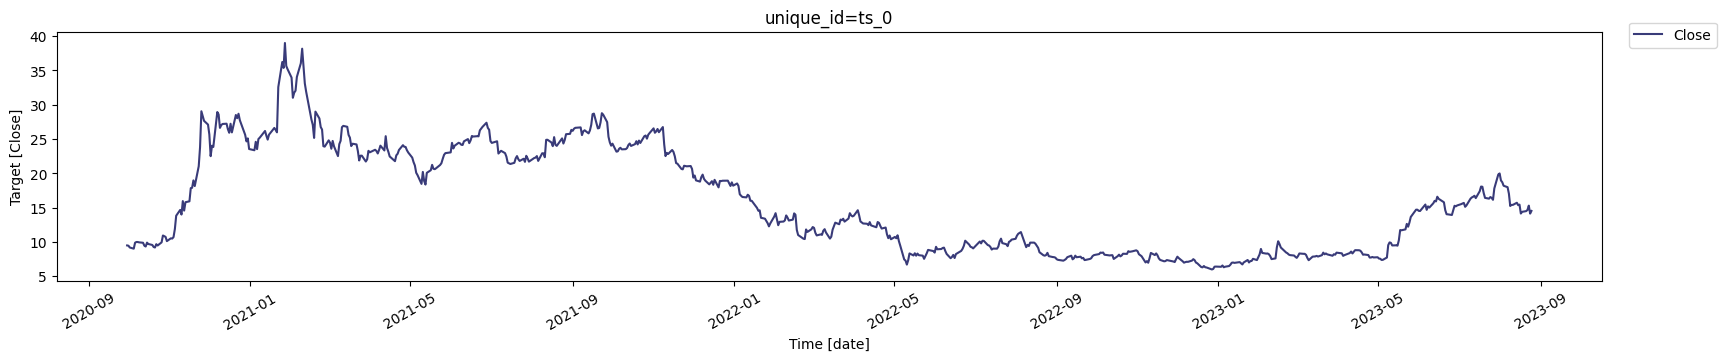

In [ ]:
pltr_df = pltr_df[['date', 'Close']]

nixtla_client.plot(pltr_df, time_col = "date", target_col = "Close")

### 3.2 Define the frequency 

To define a custom frequency, we will first extract and sort the dates from the input data, ensuring they are in the correct datetime format. Next, we will use the [`pandas_market_calendars package`](https://pypi.org/project/pandas-market-calendars/), specifically the `get_calendar` method, to obtain the New York Stock Exchange (NYSE) calendar. Using this calendar, we can create a custom frequency that includes only the days the stock market is open.

In [ ]:
dates = pd.DatetimeIndex(sorted(pltr_df['date'].unique())) # sort all dates in the dataset

nyse = mcal.get_calendar('NYSE') # New Yor Stock Exchange calendar 

Note that the days the stock market is open need to include all the dates in the input data plus the forecast horizon. In this example, we will forecast 7 days ahead, so we need to make sure our trading days include the last date in the input data as well as the next 7 valid trading days.

To avoid dealing with holidays or weekends during the forecast horizon, we will specify an end date well beyond the forecast horizon. For this example, we will use January 1, 2024, as a safe cutoff.

In [ ]:
trading_days = nyse.valid_days(start_date=dates.min(), end_date="2024-01-01").tz_localize(None)

Now, with the list of trading days, we can identify the days the stock market is closed. These are all weekdays (Monday to Friday) within the range that are not trading days. Using this information, we can define a custom frequency that skips the stock market's closed days.

In [ ]:
all_weekdays = pd.date_range(start=dates.min(), end="2024-01-01", freq='B')

closed_days = all_weekdays.difference(trading_days)

custom_bday = pd.offsets.CustomBusinessDay(holidays=closed_days)

### 3.3 Forecast with TimeGPT

With the custom frequency defined, we can now use the `forecast` method, specifying the `custom_bday` frequency in the `freq` argument. This will make the forecast respect the trading schedule of the stock market.

In [ ]:
fcst_pltr_df = nixtla_client.forecast(
    df=pltr_df, 
    h=7, 
    freq=custom_bday,
    time_col='date', 
    target_col='Close',
    level=[80, 95]
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

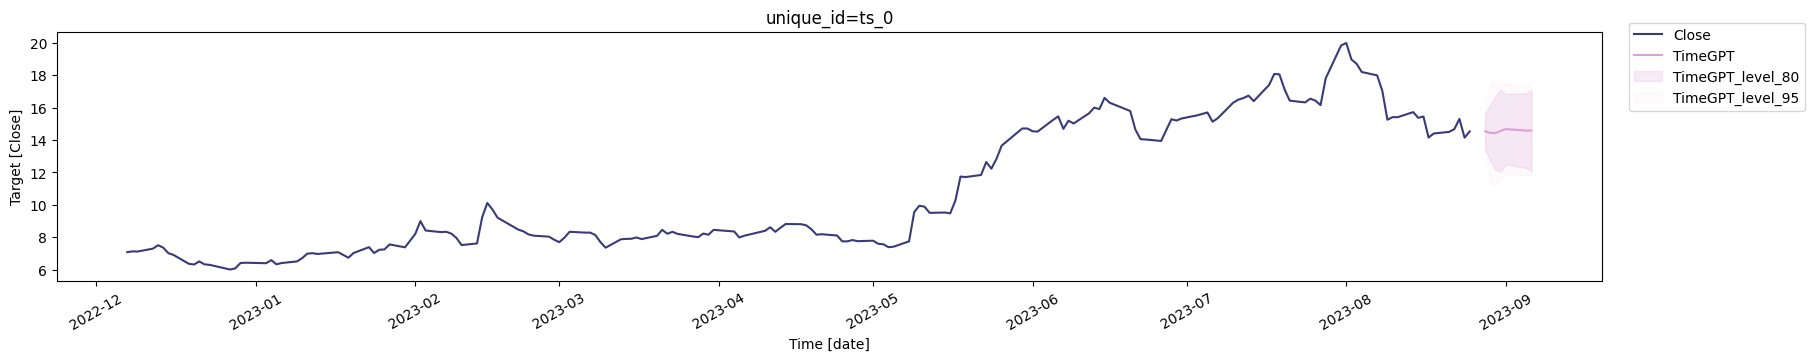

In [ ]:
nixtla_client.plot(pltr_df, fcst_pltr_df, time_col = "date", target_col = "Close", level=[80, 95], max_insample_length = 180)

In [ ]:
fcst_pltr_df[['date']].head(7)

,date
0,2023-08-28
1,2023-08-29
2,2023-08-30
3,2023-08-31
4,2023-09-01
5,2023-09-05
6,2023-09-06


Note that the forecast excludes 2023-09-04, which was a Monday when the stock market was closed for Labor Day in the United States.

## 4. Summary 
Below are the key takeaways of this tutorial:

- TimeGPT can reliably infer regular frequencies, but you can override this by setting the `freq` parameter to the corresponding pandas alias.

- When working with polars data frames, you must always specify the frequency using the correct polars offset.

- TimeGPT supports irregular frequencies and allows you to define a custom frequency, generating forecasts exclusively for the specified dates.